In [8]:
import abtem
import dask
import numpy as np
from ase.cluster import Decahedron
from dask.distributed import Client

In [63]:
gpts = 4096
sampling = 0.05
num_configs = None
n_workers = 2
threads_per_worker = 4
fft_threads = 2
interpolation = None

In [64]:
if interpolation is None:
    interpolation = max(gpts // 256, 1)
    
if num_configs is None:
    num_configs = max(8192 // gpts, 1)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x [Å]', ylabel='y [Å]'>)

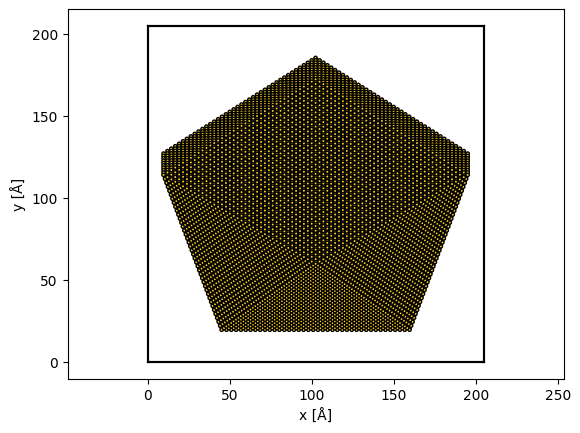

In [66]:
extent = gpts * sampling
slope = 0.19908323698251337

p = int(np.floor(slope * extent))
q = max(p // 4, 2)

atoms = Decahedron("Au", p, q, 0)
atoms.rotate("x", 30)
atoms.cell[0, 0] = atoms.cell[1, 1] = extent
atoms.center()
atoms.center(axis=2, vacuum=4)

abtem.show_atoms(atoms)

In [67]:
client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker)
client

C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61152 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61152/status,
Dashboard: http://127.0.0.1:61152/status,Workers: 2
Total threads: 8,Total memory: 31.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61155,Workers: 2
Dashboard: http://127.0.0.1:61152/status,Total threads: 8
Started: Just now,Total memory: 31.93 GiB
Comm: tcp://127.0.0.1:61178,Total threads: 4
Dashboard: http://127.0.0.1:61179/status,Memory: 15.96 GiB
Nanny: tcp://127.0.0.1:61170,


In [68]:
frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=num_configs, sigmas=0.1)

potential = abtem.Potential(
    frozen_phonons, gpts=gpts, slice_thickness=2, projection="infinite"
)
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=100e3,
    semiangle_cutoff=20,
    downsample=True,
    interpolation=interpolation,
)

detector = abtem.AnnularDetector(inner=80, outer=240)

scan = abtem.GridScan()

s_matrix.cutoff_angles

(246.70219493884275, 246.70219493884275)

In [69]:
measurements = s_matrix.scan(scan=scan, detectors=detector, disable_s_matrix_chunks=False, rechunk="auto")

In [ ]:
%%timeit -n1 -r1 -o
with abtem.config.set({"fftw.threads":fft_threads}):
    measurements.compute()

In [ ]:
time_per_phonon = _ / num_configs

In [ ]:
measurements.show()